# Foundations-2025 — Gradient Descent (batch / mini-batch / SGD)

**Purpose:** Implement and compare Batch Gradient Descent, Mini-batch Gradient Descent, and Stochastic Gradient Descent from first principles (NumPy-only). This Kaggle-ready notebook explains intuition, mathematical gradients, convergence diagnostics, and includes runnable experiments on a quadratic objective and a regression dataset.

**Usage:** Run sequentially in a Kaggle kernel. This notebook uses NumPy, scikit-learn, and matplotlib (all available by default on Kaggle).


In [1]:
# Environment check (optional)
import sys, platform, numpy as np, sklearn, matplotlib
print('Python:', sys.version.splitlines()[0])
print('Platform:', platform.platform())
print('NumPy:', np.__version__, 'scikit-learn:', sklearn.__version__, 'matplotlib:', matplotlib.__version__)


Python: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
Platform: Linux-6.6.105+-x86_64-with-glibc2.35
NumPy: 1.26.4 scikit-learn: 1.2.2 matplotlib: 3.7.2


## Imports & helper functions
Minimal utilities used across experiments.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
np.random.seed(0)

def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

def add_bias(X):
    return np.hstack([np.ones((X.shape[0],1)), X])


## Part A — Gradient Descent on a Quadratic Objective (Analytic)
**Objective:** $f(x) = \frac{1}{2} x^T A x - b^T x$ (convex quadratic). We derive gradient and compare convergence for different step sizes.

/tmp/ipykernel_47/1646895087.py:7: RuntimeWarning: overflow encountered in matmul
  return 0.5 * x.T @ A @ x - b.T @ x
/usr/local/lib/python3.11/dist-packages/matplotlib/scale.py:253: RuntimeWarning: overflow encountered in power
  return np.power(self.base, a)


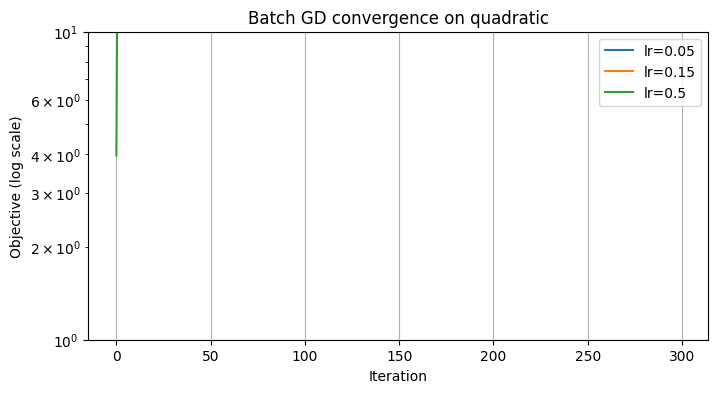

In [3]:
# Construct a diagonal positive definite matrix A for clear eigenvalues
n = 5
A = np.diag(np.linspace(1.0, 10.0, n))
b = np.random.randn(n)

def objective(x):
    return 0.5 * x.T @ A @ x - b.T @ x

def grad(x):
    return A @ x - b

def batch_gd(x0, lr, epochs):
    x = x0.copy()
    hist = np.zeros(epochs)
    for i in range(epochs):
        x -= lr * grad(x)
        hist[i] = objective(x)
    return x, hist

x0 = np.zeros(n)
_, hist1 = batch_gd(x0, lr=0.05, epochs=300)
_, hist2 = batch_gd(x0, lr=0.15, epochs=300)
_, hist3 = batch_gd(x0, lr=0.5, epochs=300)

plt.figure(figsize=(8,4))
plt.plot(hist1, label='lr=0.05')
plt.plot(hist2, label='lr=0.15')
plt.plot(hist3, label='lr=0.5')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Objective (log scale)')
plt.title('Batch GD convergence on quadratic')
plt.legend()
plt.grid(True)
plt.show()

### Observations
- For convex quadratics, convergence depends on the step size relative to eigenvalues of A.  
- Too large a step size can diverge; too small leads to slow convergence.

## Part B — Linear Regression with Batch GD, Mini-batch GD, and SGD
We apply variants of GD to a linear regression problem and compare training speed and final RMSE.

In [4]:
# Synthetic regression data
X, y = make_regression(n_samples=2000, n_features=20, noise=10.0, random_state=42)
X = add_bias(X)
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=1)

# Standardize features (excluding bias)
mean = Xtr[:,1:].mean(axis=0)
std = Xtr[:,1:].std(axis=0) + 1e-9
Xtr[:,1:] = (Xtr[:,1:] - mean) / std
Xte[:,1:] = (Xte[:,1:] - mean) / std


### Batch Gradient Descent (vectorized)

In [5]:
def batch_gradient_descent(X, y, lr=1e-3, epochs=1000):
    m, n = X.shape
    w = np.zeros(n)
    history = np.zeros(epochs)
    for ep in range(epochs):
        preds = X @ w
        grad = (1/m) * X.T @ (preds - y)
        w -= lr * grad
        history[ep] = 0.5 * np.mean((preds - y) ** 2)
    return w, history

w_bgd, hist_bgd = batch_gradient_descent(Xtr, ytr, lr=5e-4, epochs=2000)
print('BGD train RMSE (approx):', rmse(ytr, Xtr @ w_bgd))
print('BGD test RMSE:', rmse(yte, Xte @ w_bgd))


BGD train RMSE (approx): 63.74741023359894
BGD test RMSE: 62.73313164633384


### Stochastic Gradient Descent (per-sample update)

In [6]:
def sgd(X, y, lr=1e-3, epochs=5):
    m, n = X.shape
    w = np.zeros(n)
    hist = []
    for ep in range(epochs):
        idx = np.random.permutation(m)
        for i in idx:
            xi = X[i:i+1]
            yi = y[i:i+1]
            pred = xi @ w
            grad = xi.T @ (pred - yi)
            w -= lr * grad
        # record training loss after each epoch
        preds = X @ w
        hist.append(0.5 * np.mean((preds - y) ** 2))
    return w, np.array(hist)

w_sgd, hist_sgd = sgd(Xtr, ytr, lr=1e-4, epochs=20)
print('SGD train RMSE (approx):', rmse(ytr, Xtr @ w_sgd))
print('SGD test RMSE:', rmse(yte, Xte @ w_sgd))


SGD train RMSE (approx): 12.196085317156886
SGD test RMSE: 12.666186992832994


### Mini-batch Gradient Descent

In [7]:
def minibatch_gd(X, y, lr=1e-3, epochs=10, batch_size=64):
    m, n = X.shape
    w = np.zeros(n)
    history = []
    for ep in range(epochs):
        idx = np.random.permutation(m)
        Xs = X[idx]; ys = y[idx]
        for i in range(0, m, batch_size):
            xb = Xs[i:i+batch_size]
            yb = ys[i:i+batch_size]
            pred = xb @ w
            grad = (1/xb.shape[0]) * xb.T @ (pred - yb)
            w -= lr * grad
        preds = X @ w
        history.append(0.5 * np.mean((preds - y) ** 2))
    return w, np.array(history)

w_mbgd, hist_mbgd = minibatch_gd(Xtr, ytr, lr=5e-4, epochs=50, batch_size=128)
print('MBGD train RMSE (approx):', rmse(ytr, Xtr @ w_mbgd))
print('MBGD test RMSE:', rmse(yte, Xte @ w_mbgd))


MBGD train RMSE (approx): 125.50616439647804
MBGD test RMSE: 122.11079447642933


### Compare convergence curves (BGD vs MBGD vs SGD)

ValueError: x and y must have same first dimension, but have shapes (2000,) and (50,)

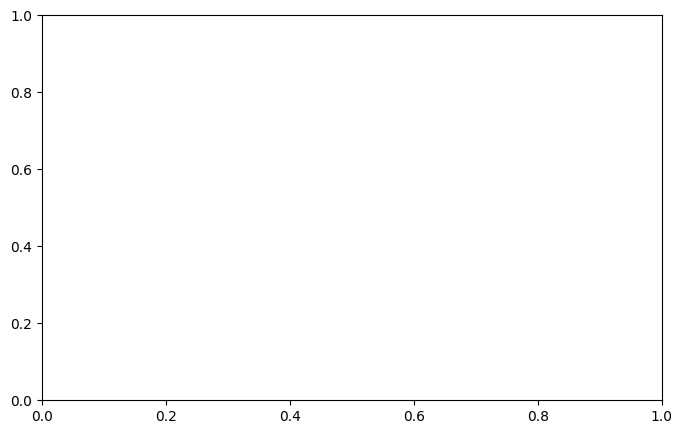

In [8]:
# For fair plotting, align histories (epochs)
# hist_bgd: per iteration (2000), hist_mbgd: per epoch (50), hist_sgd: per epoch (20)
plt.figure(figsize=(8,5))
# plot BGD sampled to match epoch counts roughly
plt.plot(np.linspace(0,50,len(hist_bgd)), hist_bgd.reshape(-1)[::len(hist_bgd)//50], label='BGD (sampled)')
plt.plot(np.arange(len(hist_mbgd)), hist_mbgd, label='MBGD (per-epoch)')
plt.plot(np.arange(len(hist_sgd)), hist_sgd, label='SGD (per-epoch)')
plt.yscale('log')
plt.xlabel('Epoch (approx)')
plt.ylabel('Training objective (log scale)')
plt.title('GD variants convergence comparison')
plt.legend()
plt.grid(True)
plt.show()

## Part C — Practical tips & diagnostics
- Feature scaling (standardization) is often required for fast convergence.  
- Use learning rate schedules (decay) for SGD.  
- Use momentum or adaptive optimizers (Adam/Adagrad) for noisy gradients.  
- Monitor training objective, validation loss, and gradient norms to detect divergence.  

**Extensions:** Add momentum, Nesterov acceleration, Adam optimizer, and compare.


### Extension: SGD with Momentum (simple implementation)

In [ ]:
def sgd_momentum(X, y, lr=1e-3, epochs=10, batch_size=64, momentum=0.9):
    m, n = X.shape
    w = np.zeros(n)
    v = np.zeros(n)
    history = []
    for ep in range(epochs):
        idx = np.random.permutation(m)
        Xs = X[idx]; ys = y[idx]
        for i in range(0, m, batch_size):
            xb = Xs[i:i+batch_size]; yb = ys[i:i+batch_size]
            pred = xb @ w
            grad = (1/xb.shape[0]) * xb.T @ (pred - yb)
            v = momentum * v + lr * grad
            w -= v
        preds = X @ w
        history.append(0.5 * np.mean((preds - y) ** 2))
    return w, np.array(history)

w_mom, hist_mom = sgd_momentum(Xtr, ytr, lr=5e-4, epochs=50, batch_size=128, momentum=0.9)
print('SGD+Momentum test RMSE:', rmse(yte, Xte @ w_mom))


## Part D — Checklist before adding to your portfolio
1. Clean outputs and add short narrative about experiments.  
2. Add hyperparameter table (learning rates, batch sizes, epochs) and final metrics.  
3. Consider saving final models (weights) as `.npy` files and include a model_card describing limitations.
